In [1]:
import vizdoom as vzd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
possible_actions = np.zeros((6,4),dtype=int).tolist()
possible_actions[0] = [1,0,0,0]
possible_actions[1] = [0,1,0,0]
possible_actions[2] = [0,0,-45,0]
possible_actions[3] = [0,0,45,0]
possible_actions[4] = [0,0,0,10]
possible_actions[5] = [0,0,0,-10]

possible_actions

[[1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, -45, 0],
 [0, 0, 45, 0],
 [0, 0, 0, 10],
 [0, 0, 0, -10]]

In [3]:
import numpy as np

def is_visible_segment(raw_map, start_row, end_row, col):
    """Проверяет видимость в сегменте по заданному столбцу."""
    for row in range(start_row, end_row + 1):
        if raw_map[row, col, 0] == 255:  # Если пиксель белый
            return False
    return True

def process_segment(raw_map, start_row, end_row, col_start, col_end, map):
    """Обрабатывает сегмент карты для определения видимости."""
    for col in range(col_end,col_start-1,-1):
        # Проверяем видимость сверху
        if is_visible_segment(raw_map, start_row, end_row, col):
            map[start_row, col, :] = [0, 0, 0]  # Обозначаем как видимый

def divide_and_conquer(raw_map: np.array):
    # Заменяем значения больше 100 на белый цвет
    raw_map[raw_map[:, :, 0] > 100] = 255
    raw_map[raw_map[:, :, 1] > 100] = 255
    raw_map[raw_map[:, :, 2] > 100] = 255
    raw_map[118:121, 158:161, :] = [255, 0, 0]

    map = np.ones_like(raw_map) * 255

    # Определяем границы для обработки
    height = raw_map.shape[0]
    width = raw_map.shape[1]

    # Разделяем и обрабатываем по строкам
    for row in range(120, -1, -1):
        left_col = -1
        right_col = -1
        
        # Ищем правую границу видимости
        for j in range(159, width):
            if raw_map[row, j, 0] != 255:
                right_col = j
                break
        
        # Ищем левую границу видимости
        for j in range(158, -1, -1):
            if raw_map[row, j, 0] != 255:
                left_col = j
                break
        
        if right_col != -1:
            map[row, right_col, :] = [0, 0, 0]
        if left_col != -1:
            map[row, left_col, :] = [0, 0, 0]

    # Обработка столбцов для видимости снизу
    for col in range(width):
        top_row = -1
        
        for i in range(118, -1, -1):
            if raw_map[i, col, 0] != 255:
                top_row = i
                break
        
        if top_row != -1:
            map[top_row, col, :] = [0, 0, 0]

    #map[118:121, 158:161,:] = [255,0,0]
    
    return map

# Пример использования функции
# raw_map должен быть загружен заранее как NumPy массив.
# processed_map = divide_and_conquer(raw_map)

In [4]:
def map_processing(raw_map: np.array):
    raw_map[raw_map[:,:,0] > 100] = 255  # Replace all values greater than 100 with 255
    raw_map[raw_map[:,:,1] > 100] = 255  # Replace all values greater than 100 with 255
    raw_map[raw_map[:,:,2] > 100] = 255  # Replace all values greater than 100 with 255
    raw_map[118:121,158:161,:] = [255,0,0]

    map = np.ones_like(raw_map)*255
    for i in range(120,-1,-1):
        j = 159
        while j!=320 and raw_map[i,j,0] == 255:
            j += 1
        if j!=320:
            map[i,j,:] = [0,0,0]
        j = 158
        while j!=0 and raw_map[i,j,0] == 255:
            j -= 1
        if j!=-1:
            map[i,j,:] = [0,0,0]
    for j in range(0,raw_map.shape[1]):
        i = 118
        while i!=0 and raw_map[i,j,0] == 255:
            i -= 1
        if i!=0:
            map[i,j,:] = [0,0,0]
    map[118:121,158:161,:] = [255,0,0]        
    return map
# duration 4 tics
def get_pictures(game: vzd.DoomGame):
    state = game.get_state()    
    st = state.screen_buffer.transpose(1,2,0)
    img = np.array([st])
    # turn left
    game.make_action(possible_actions[2])
    state = game.get_state()
    st = state.screen_buffer.transpose(1,2,0)
    img = np.append(img, [st], axis=0)
    dm = state.automap_buffer.transpose(1,2,0)
    debug_map = np.array([dm])
    # turn right
    game.make_action(possible_actions[3],2)
    state = game.get_state()
    st = state.screen_buffer.transpose(1,2,0)
    img = np.append(img, [st], axis=0)
    dm = state.automap_buffer.transpose(1,2,0)
    debug_map = np.append(debug_map, [dm], axis=0)
    # return to center
    game.make_action(possible_actions[2])
    state = game.get_state()
    dm = state.automap_buffer.transpose(1,2,0)
    debug_map = np.append(debug_map, [dm], axis=0)
    auto_map = state.automap_buffer.transpose(1,2,0)
    #processed_map = map_processing(auto_map)
    processed_map = divide_and_conquer(auto_map)
    #processed_map = tracing(auto_map)
    return img, auto_map, processed_map,debug_map

In [34]:
game = vzd.DoomGame()
game.load_config('resources/temp_maps/datagen.cfg')
game.set_doom_scenario_path('data/mazemaker_maps/15x15.wad')
game.set_automap_mode(vzd.AutomapMode.NORMAL)
game.set_objects_info_enabled(True)
game.set_labels_buffer_enabled(True)
for i in range(100):
    game.set_seed(i)
    game.init()
    game.new_episode()
    state = game.get_state()
    st = state.screen_buffer.transpose(1,2,0)
    img = np.array([st])
    am = state.automap_buffer.transpose(1,2,0)
    dph = np.array([state.depth_buffer])
    tmp_img, auto_map, tmp_processed_map, debug_map = get_pictures(game)
    tmp_position = state.game_variables
    objects = state.objects
    if i==0:
        images = np.array([tmp_img])
        maps = np.array([tmp_processed_map])
        positions = np.array([tmp_position])
        depth = np.array(dph)
    else:
        images = np.append(images,[tmp_img],axis=0)
        maps = np.append(maps,[tmp_processed_map],axis=0)
        positions = np.append(positions,[tmp_position],axis=0)    
        depth = np.append(depth,dph,axis=0)   
    game.close()

In [44]:
print(len(objects))
for i in range(len(objects)):
    print(f'{objects[i].name}: x={objects[i].position_x}, y={objects[i].position_y}, z={objects[i].position_z}, angle={objects[i].angle}')

2
DoomPlayer: x=1476.0163269042969, y=868.1015625, z=0.0, angle=60.68298341256636
RedCard: x=693.0, y=434.0, z=0.0, angle=180.00000004190952


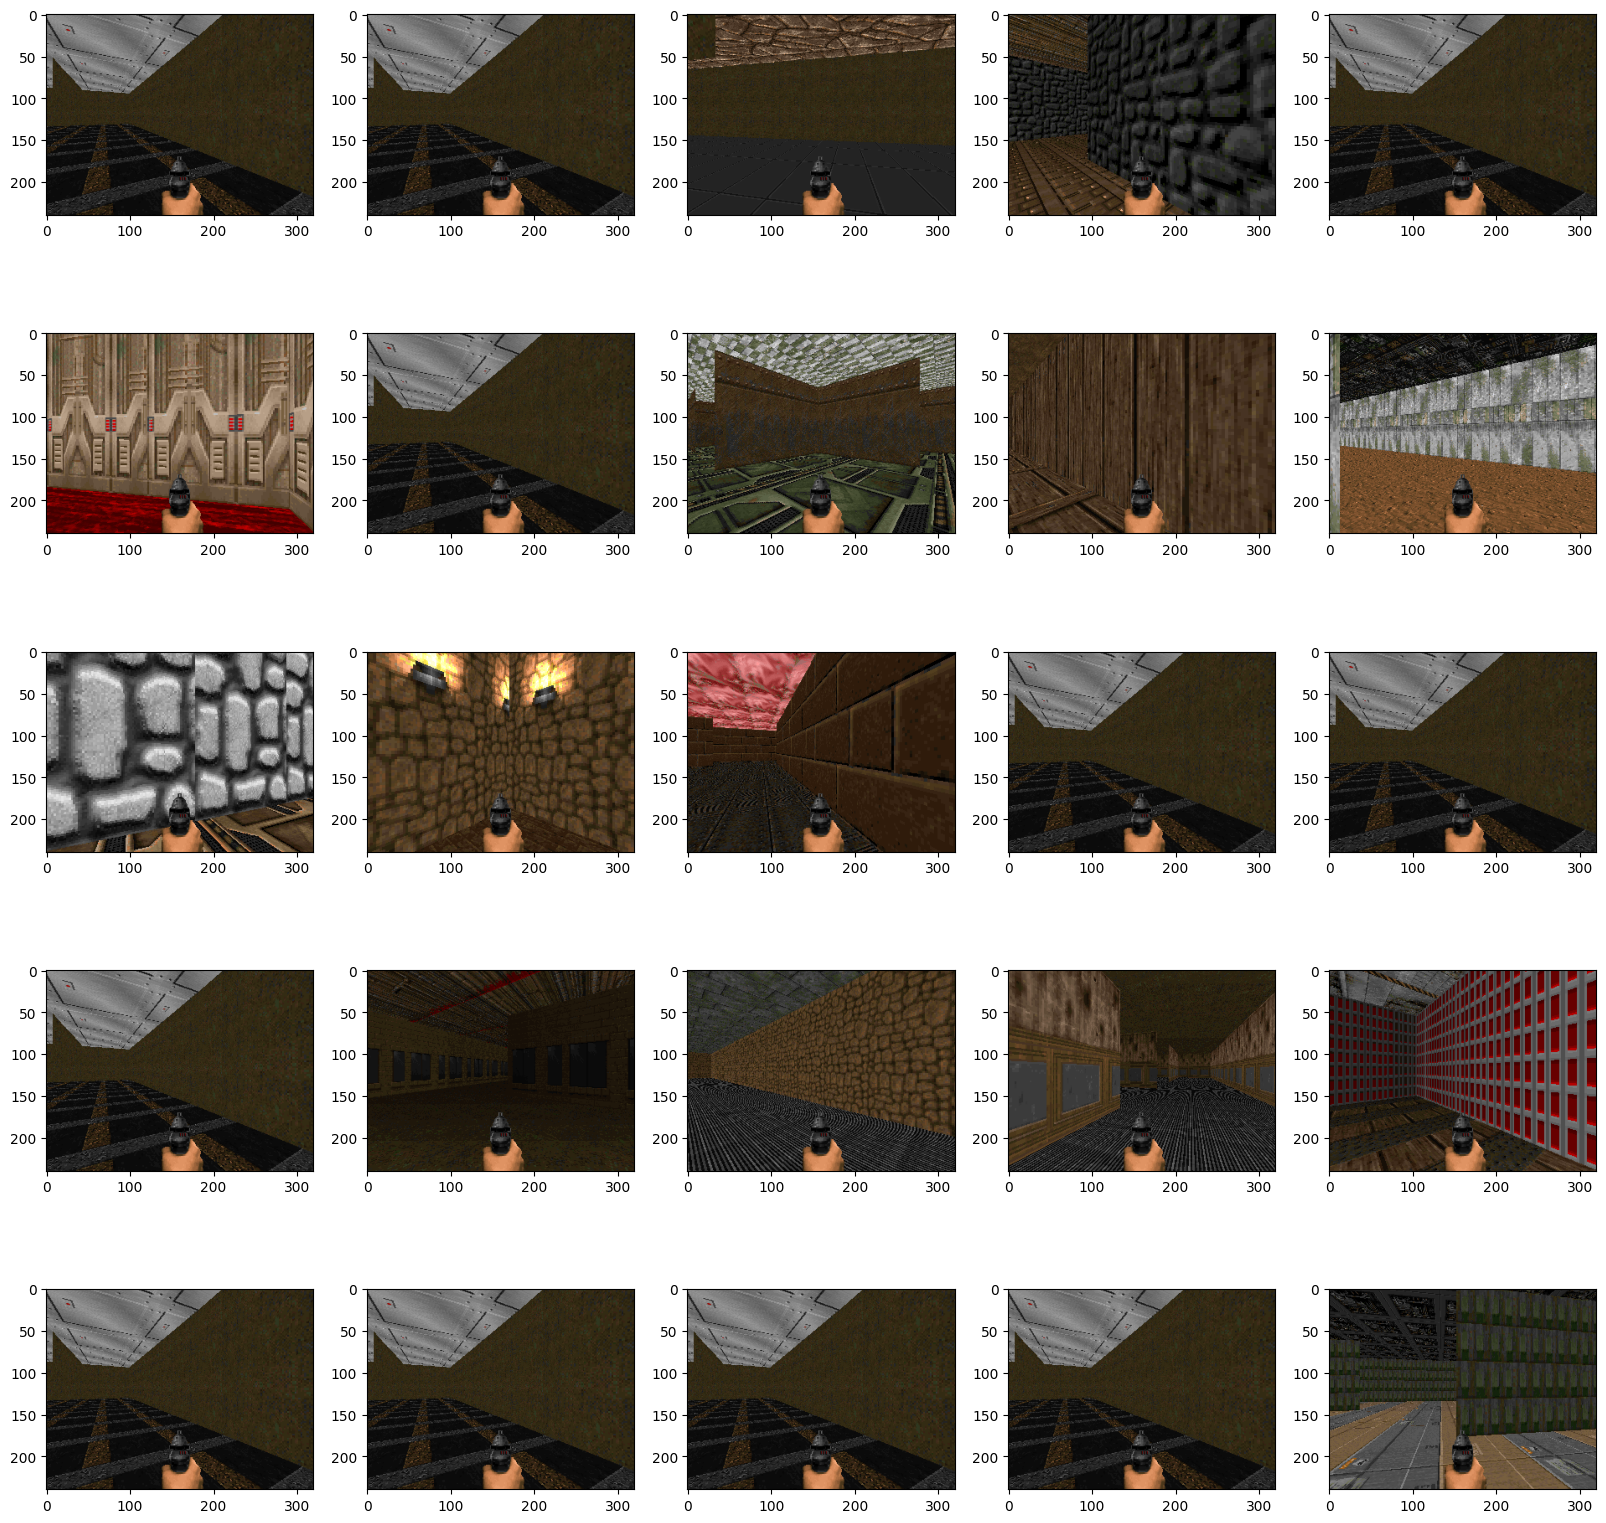

In [50]:
fig, ax = plt.subplots(5,5,figsize=(20,20))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[i*5+j,0])
plt.show()


In [40]:
positions_list = [{'x': pos[0], 'y': pos[1], 'z': pos[2], 'angle': pos[3]} for pos in positions]
np.savez('data/map1_data.npz', images=images, maps=maps, positions=positions_list,depth=depth,objects=objects)

In [52]:
# Print all positions
[print(f'x={a['x']}, y={a['y']}, z={a['z']}, angle={a['angle']}') for a in positions_list]

# Get unique x,y coordinate pairs
unique_positions = set((pos['x'], pos['y']) for pos in positions_list)
print(f"\nNumber of unique (x,y) positions: {len(unique_positions)}")

x=1476.0163269042969, y=868.1015625, z=0.0, angle=60.68298341256636
x=1476.0163269042969, y=868.1015625, z=0.0, angle=60.68298341256636
x=878.8865966796875, y=1338.0102996826172, z=0.0, angle=101.22802736731899
x=1249.3342742919922, y=1071.9305419921875, z=0.0, angle=313.76953132305516
x=1476.0163269042969, y=868.1015625, z=0.0, angle=60.68298341256636
x=1488.8721008300781, y=1531.221908569336, z=0.0, angle=190.38208012245178
x=1476.0163269042969, y=868.1015625, z=0.0, angle=60.68298341256636
x=661.58251953125, y=1029.5327911376953, z=0.0, angle=221.62170415316282
x=180.13064575195312, y=344.8828887939453, z=0.0, angle=39.336547860721254
x=456.0449523925781, y=1076.643798828125, z=0.0, angle=208.2733154781799
x=155.45095825195312, y=953.6021423339844, z=0.0, angle=339.85107429787774
x=1467.6954803466797, y=1494.9478607177734, z=0.0, angle=133.84643557803855
x=868.7358703613281, y=768.7713165283203, z=0.0, angle=245.99487310415014
x=1476.0163269042969, y=868.1015625, z=0.0, angle=60.682

In [13]:
data = np.load('data/mywayhome_data.npz')
d1 = data['maps']
d2 = data['images']
d3 = data['positions']
#positions_list = [{'x': pos[0], 'y': pos[1], 'z': pos[2], 'angle': pos[3]} for pos in d3]
[print(f'x={a['x']}, y={a['y']}, z={a['z']}, angle={a['angle']}') for a in positions_list]



x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=686.64599609375, y=-62.38200378417969, z=0.0, angle=109.73144533804884
x=1039.3280029296875, y=-169.88400268554688, z=0.0, angle=285.8917236993768
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=460.3260040283203, y=-596.1199951171875, z=0.0, angle=184.41101078512403
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=464.09800720214844, y=-60.496002197265625, z=0.0, angle=13.37036133123803
x=460.3260040283203, y=-596.1199951171875, z=0.0, angle=117.81188967586772
x=464.0, y=-176.0, z=0.0, angle=354.4024659028282
x=464.0, y=-176.0, z=0.0, angle=221.5008545437597
x=460.3260040283203, y=56.436004638671875, z=0.0, angle=147.35412601087106
x=686.8300018310547, y=-173.2469940185547, z=0.0, angle=120.9265137000304
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

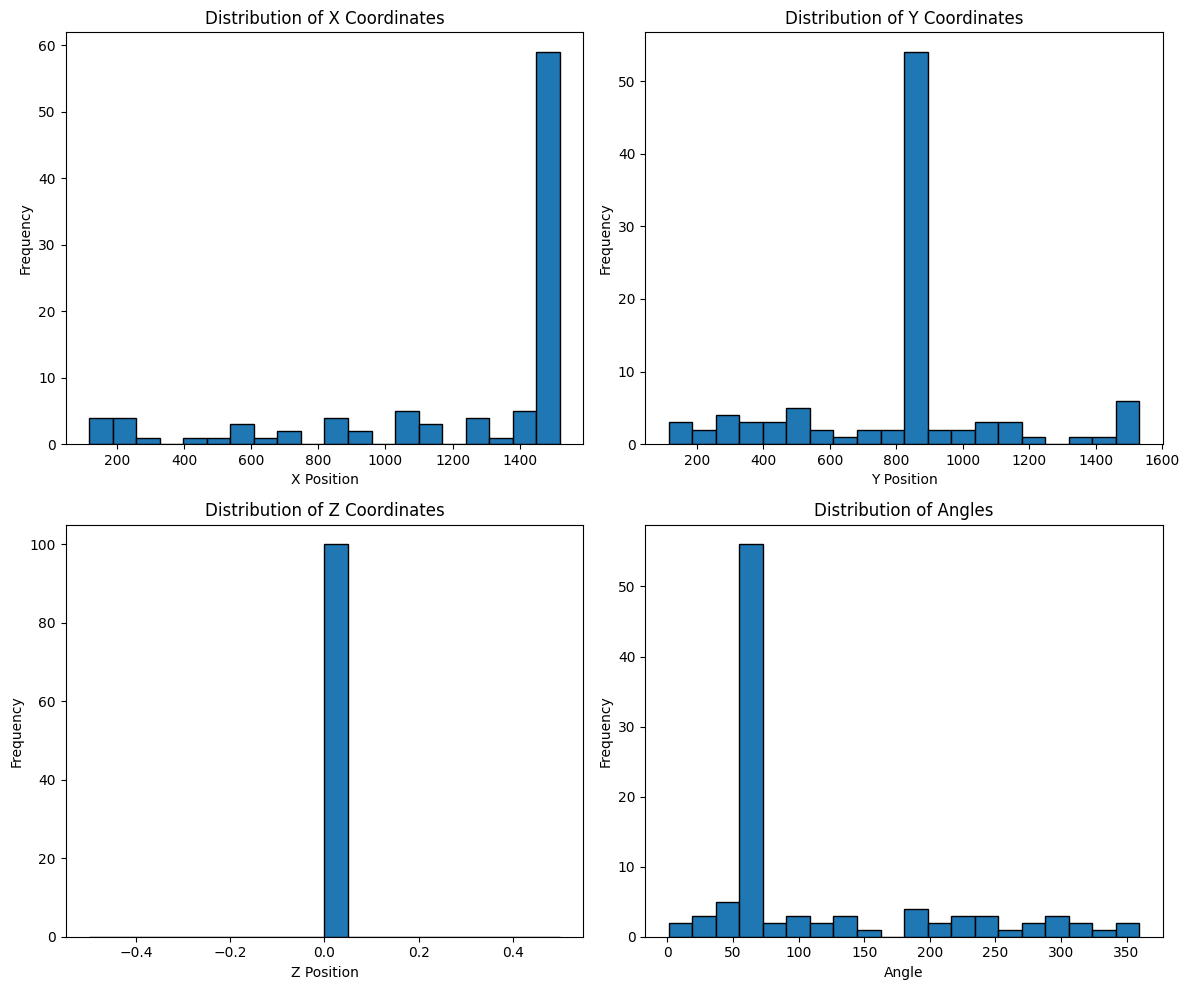

In [41]:
# Create separate lists for each coordinate
x_coords = [pos['x'] for pos in positions_list]
y_coords = [pos['y'] for pos in positions_list]
z_coords = [pos['z'] for pos in positions_list]
angles = [pos['angle'] for pos in positions_list]

# Create subplots for distributions
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms
ax1.hist(x_coords, bins=20, edgecolor='black')
ax1.set_title('Distribution of X Coordinates')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Frequency')

ax2.hist(y_coords, bins=20, edgecolor='black')
ax2.set_title('Distribution of Y Coordinates')
ax2.set_xlabel('Y Position')
ax2.set_ylabel('Frequency')

ax3.hist(z_coords, bins=20, edgecolor='black')
ax3.set_title('Distribution of Z Coordinates')
ax3.set_xlabel('Z Position')
ax3.set_ylabel('Frequency')

ax4.hist(angles, bins=20, edgecolor='black')
ax4.set_title('Distribution of Angles')
ax4.set_xlabel('Angle')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


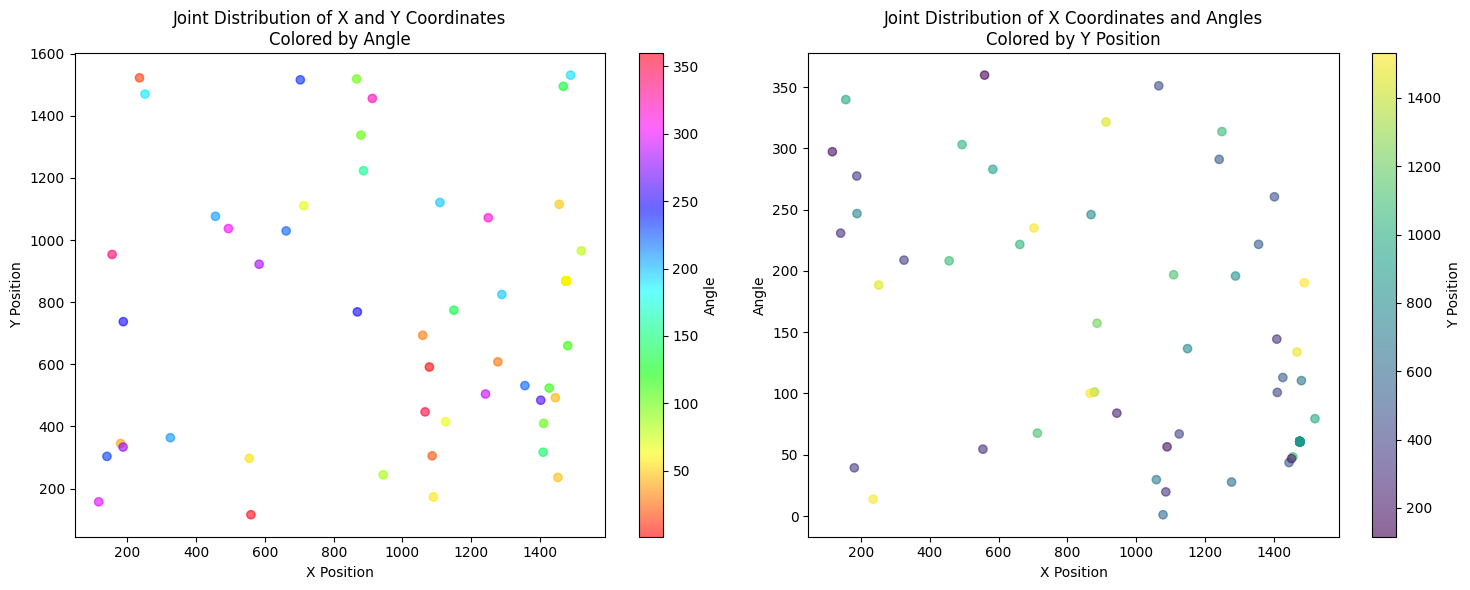

In [42]:
# Create figure for joint distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot X vs Y scatter
scatter = ax1.scatter(x_coords, y_coords, c=angles, cmap='hsv', alpha=0.6)
ax1.set_title('Joint Distribution of X and Y Coordinates\nColored by Angle')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
plt.colorbar(scatter, ax=ax1, label='Angle')

# Plot angle distribution vs X position
scatter2 = ax2.scatter(x_coords, angles, c=y_coords, cmap='viridis', alpha=0.6)
ax2.set_title('Joint Distribution of X Coordinates and Angles\nColored by Y Position')
ax2.set_xlabel('X Position')
ax2.set_ylabel('Angle')
plt.colorbar(scatter2, ax=ax2, label='Y Position')

plt.tight_layout()
plt.show()


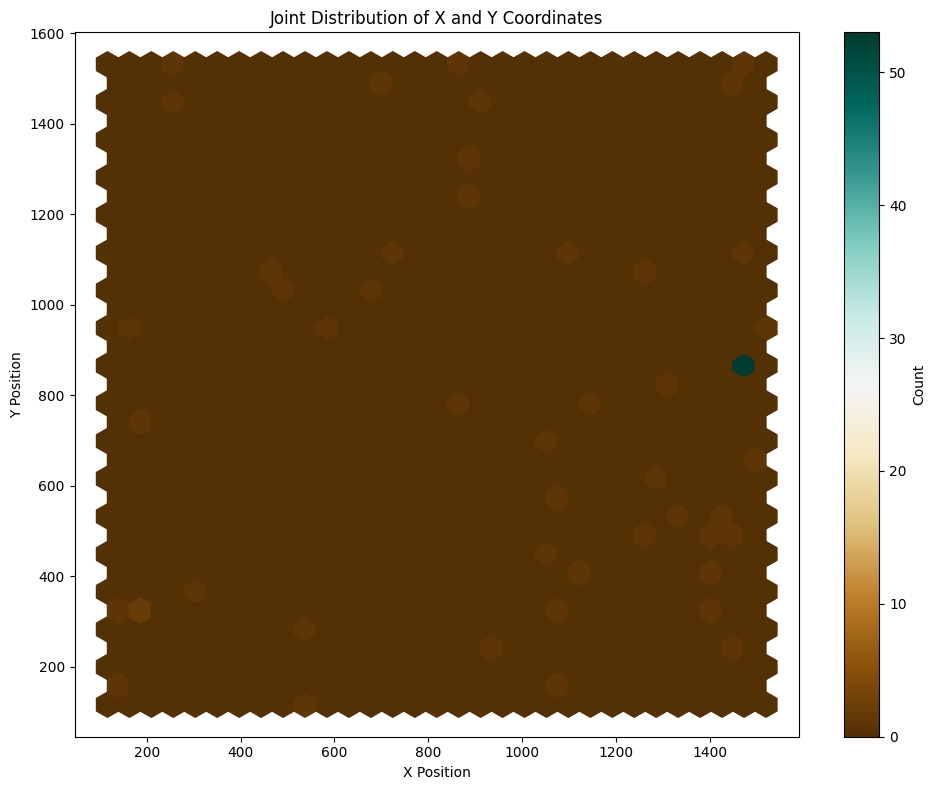

In [43]:
# Create figure for joint distribution
plt.figure(figsize=(10, 8))

# Create joint distribution plot using hexbin
plt.hexbin(x_coords, y_coords, gridsize=30, cmap='BrBG') # YlOrRd
plt.colorbar(label='Count')

plt.title('Joint Distribution of X and Y Coordinates')
plt.xlabel('X Position')
plt.ylabel('Y Position')

plt.tight_layout()
plt.show()
